# Pulse-shaping for Linearly Modulated Signals

This notebook focuses on pulse-shaping for linearly modulated signal. We will see the impact that pulse-shaping has on the spectrum of the modulated signals. The pulse shape also determines if adjacent symbols interfere with each other; the Nyquist criterion provides a simple condition that guarantees that no such interference occurs. Practical considerations for the selection of pulse shapes are illustrated. Throughout this notebook, we ignore channel noise and focus purely on the properties of the information bearing signal.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/030_pulse_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/030_pulse_shaping.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [2]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Linearly Modulated Signals and their Spectra

A linearly modulated signal $s(t)$ is constructed from  information symbols $s_n$ drawn from a constellation $\cal A$ and  pulse shape $p(t)$:
$$
    s(t) = \sum_n s_n \cdot p(t-nT).
$$

Usually, the information symbols $s_n$ have zero mean ($\text{\bf E}[s_n]=0$) and are uncorrelated
$$
\text{\bf E}[s_n s_m^*] = \begin{cases}
    \sigma_s^2 & \text{when $n=m$}\\
    0 & \text{when $n \neq m$,}
\end{cases}
$$
where $\sigma_s^2 = \text{\bf E}[|s_n|^2]$ is the variance of the information symbols. Recall that it is common to normalize the constellation such that $\sigma_s^2=1$.

Then, Power Spectral Density (PSD) of the linearly modulated signal $s(t)$ is given by
$$
    S(f) = \frac{\sigma^2}{T} |P(f)|^2,
$$
wher $P(f)$ is the Fourier Transform of $p(t)$.

### Example: recatanglar and triangular pulse

Let $p(t)$ be a triangular pulse of width $T$, i.e.,
$$
p(t) = \begin{cases}
    2t & \text{for $0 \leq t <T/2$} \\
    2(T-t) & \text{for $T/2 \leq < T$} \\
    0 & \text{else.}
\end{cases}
$$

The Fourier transform of $p(t)$ is equal to
$$
P(f) = \frac{T}{2} \text{sinc}^2(\frac{\pi}{2}fT)
$$

And, the PSD of a linearly, modulated signal with these pulse is 
$$
S(f) = \frac{\sigma^2 T}{4} \text{sinc}^4(\frac{\pi}{2}fT)
$$

Similarly, for a rectangular pulse of duration $T$,
$$
p(t) = \begin{cases}
    1 & \text{for $0 \leq t <T$}\\
    0 & \text{else}
    \end{cases}
$$
the PSD equals
$$
S(f) = \sigma^2 T \text{sinc}^2(\pi fT).
$$


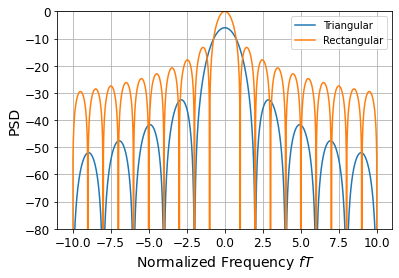

In [37]:
# plot PSD of triangular pulse
sigma_sq = 1
T = 1
fsT = 20
fT = np.linspace(-fsT/2, fsT/2, 1001)
S_t = sigma_sq/4 * (np.sinc(fT/2))**4  # note: np.sinc(x) = sin(pi*x)/(pi*x)
S_r = sigma_sq * (np.sinc(fT))**2     # note: np.sinc(x) = sin(pi*x)/(pi*x)


plt.plot(fT, 10*np.log10(S_t))
plt.plot(fT, 10*np.log10(S_r))

plt.ylim([-80,0])
plt.grid()

plt.xlabel('Normalized Frequency $fT$')
plt.ylabel('PSD')

plt.legend(['Triangular', 'Rectangular'])

plt.show()

Both pulses have a clearly defined main-lobe and multiple sidelobes.

The rectangular pulse has a narrower mainlobe (two-sided width: $2/T$). The two-sided width for the triangular pulse is $4/T$.

The sildelobes of the triangular pulse decay faster ($\sim 1/f^4$) than those of the rectangular pulse ($\sim 1/f^2$)

### Measures of Bandwidth

To quantify the bandwidth occupied by a linearly modulated signal, it is useful to define metrics that capture bandwidth in a single quantity.
The following metrics are commonly used for this purpose:

* **Zero-to-Zero Bandwidth:** is the width between the two zeros on either side of the main-lobe. This is easy to measure. But, not all pulse shapes have spectra zeros (e.g., a Gaussian pulse).

* **3dB Bandwidth:** is the width between the frequencies where the PSD has dropped 3dB from its peak. I.e., the two-sided bandwidth $B_{3dB}$ satisfies 
$$
S(B_{3dB}/2) = 0.5 \cdot S(0).
$$ 
This is again easy to measure. The resulting metric is often too optimistic and does not account for the sidelobes.

* **Fractional Energy Containment Bandwidth:** is defined as the two-sided bandwidth $B_a$ that contains a fraction $0 < a < 1$ of the energy of the entire signal. Specifically, $B_a$ is defined by the relationship
$$
\int_{-B_a/2}^{B_a/2} S(f) \, df = a \cdot \int_{-\infty}^{\infty} S(f) \, df.
$$
This metric must usually be evaluated numerically. However, it provides a comprehensive measure of bandwidth, including the sidelobe roll-off. Useful values for $a$ are $a=0.99$ and $a=0.9$.

Below are functions to compute 3dB-bandwidth and fractional containment bandwidth.



In [44]:
def measure_containment_bw(psd, a, fsT):
    """measure the bandwidth that contains fraction a of the energy
    
    Inputs:
    psd - vector containing samples of the PSD
    a - fraction of the energy
    fsT - time-domain oversampling factor; frequency axis spans from -fsT/2 to fsT/2

    Returns:
    measured bandwidth in terms of multiples of 1/T

    Notes: the psd vector is assumed to be two-sided, i.e., span both positive and negative frequencies. 
    To give meaningful results, it must be oversampled significantly in time and frequency. Specifically,
    the oversampling factor in time, `fsT`, must be much greater than 1 and the ratio of length of `psd` 
    to `fsT` must also be much greater than 1.
    """
    # "integrate" psd
    psd_int = np.sum(psd)    # total energy
    psd_cs = np.cumsum(psd)  # running energy total

    # find places where we cross (1-a)/2 and (1+a)/2
    l_ind = np.argmin( np.abs(psd_cs - (1-a)/2*psd_int) )
    h_ind = np.argmin( np.abs(psd_cs - (1+a)/2*psd_int) )

    return (h_ind - l_ind) / len(psd) * fsT

In [45]:
def measure_3dB_bw(psd, fsT):
    """measure the bandwidth between the 3dB drop-off points
    
    Inputs:
    psd - vector containing samples of the PSD
    fsT - time-domain oversampling factor; frequency axis spans from -fsT/2 to fsT/2

    Returns:
    measured bandwidth in terms of multiples of 1/T

    Notes: the psd vector is assumed to be two-sided, i.e., span both positive and negative frequencies. 
    To give meaningful results, it must be oversampled significantly in time and frequency. Specifically,
    the oversampling factor in time, `fsT`, must be much greater than 1 and the ratio of length of `psd` 
    to `fsT` must also be much greater than 1.
    """
    # 
    ind_max = np.argmax(psd)  # location of max
    psd_max = psd[ind_max]    # max energy

    # find places where psd is closest to half of max PSD,
    # this may happen on either side of the frequency axis
    ind_3dB = np.argmin( np.abs(psd - 0.5*psd_max) )

    return 2*np.abs(ind_3dB - ind_max) / len(psd) * fsT

In [43]:
# Compare Rectangular and Triangular Pulses in terms of bandwidth metrics
print("{:<30s} {:^30s} {:^30s}". format("", "Rectangular Pulse", "Triangular Pulse"))
print("{:<30s} {:^24.4f} * 1/T {:^24.4f} * 1/T".format("Zero-to-Zero BW", 2, 4))
print("{:<30s} {:^24.4f} * 1/T {:^24.4f} * 1/T".format("3dB BW", 
    measure_3dB_bw(S_r, fsT), 
    measure_3dB_bw(S_t, fsT)))
print("{:<30s} {:^24.4f} * 1/T {:^24.4f} * 1/T".format("99% Containment BW", 
    measure_containment_bw(S_r, 0.99, fsT), 
    measure_containment_bw(S_t, 0.99, fsT)))

                                     Rectangular Pulse               Triangular Pulse       
Zero-to-Zero BW                         2.0000          * 1/T          4.0000          * 1/T
3dB BW                                  0.8791          * 1/T          1.2787          * 1/T
99% Containment BW                     10.4096          * 1/T          2.5774          * 1/T


## The Nyquist Criterion and Nyquist Pulses

So far, we have only considered full-response pulse-shaping, i.e., pulses that only span a single symbol period. 

We know that longer pulses (can) have narrower Fourier Transforms. Hence, a valid question is: *Can we use pulses that are longer than a single symbol period?*

To answer this question, we need to include the receiver filter $h_r(t)$ (usually, the matched filter) in our considerations. In fact, if the signal experiences dispersion (undesired filtering by the channel), then the channel filter $h_c(t)$ should be included as well. We will return to this observation when we discuss equalization in a few weeks.

Relevane for our discussion is the cascade of transmit filter $p(t)$ and receiver filter $h_r(t)$. The effective filter that the information symbols see is therefore $h(t) = p(t) \ast h_r(t)$. 

Put differently, in the receiver the signal that is input to the symbol-rate sampler is
$$
    z(t) = s(t) \ast h_r(t) = \sum_m s_m p(t-mT) \ast h_r(t) = \sum_m s_m h(t-mT).
$$

The symbol rate samples $z(nT)$ are then given by
$$
    z(nT) = \sum_m s_m h(nT-mT).
$$

**Question:** Under what condition on $h(t)$ are the samples $z(nT)$ equal to the information symbols $s_n$? 

### The Nyquist Criterion

The symbol rate samples out of the receiver frontend are given by
$$
    z(nT) = \sum_m s_m h(nT-mT).
$$
and we want them to equal $s_n$. That way, the information symbols can be recovered without interference from other symbols $s_m$ for $m \neq n$ (Intersymbol Interference, ISI). 

**Time-domain Nyquist Criterion** If the impulse response of the cascade $h(t)$ is such that
$$
    h(nT) = \begin{cases}
    1 & \text{for $n=0$}\\
    0 & \text{for $n \neq 0$,}
    \end{cases}
$$
then samples $z(nT)$ are free of intersybol interference.

An equivalent condition in the frequency domain is:

**Frequency-domain Nyquist Criterion** To avoid ISI when the symbol rate is $\frac{1}{T}$, the frequency response $H(f)$ of the cascade $h(t)$ must satisfy
$$
    \frac{1}{T} \sum_k H(f + \frac{k}{T}) = 1 \text{ for all $f$.}
$$

**Question:** What kind of impulse responses $h(t)$ satisfy the Nyquist Criterion?

### Nyquist Pulses

Pulses that meet the Nyquist Criterion include the following two categories:

1. **Full-repsonse pulses:** All pulses that are of finite duration, such that
$$
    h(t) = 0 \text{ for $|t| \geq T$}
$$
obviously satsfy the time-domain condition.

*Remark:* Notice that $h(t)$ as defined above has width up to $2T$. Recall that $h(t)$ is the cascade of $p(t)$ and $h_r(t)$. Thus, the width of $h(t)$ equals the sum of the widths of $p(t)$ and $h_r(t)$. This implies that $p(t)$ has duration $T$.

2. **$\text{sinc}$-type pulses** Pulses of the form
$$
h(t) = a(t/T) \cdot \text{sinc}(\pi t/T) \text{ with $a(0)=1$}
$$
have zeros at $t=nT$ for $n \neq 0$ and $h(0)=1$. Thus, they meet the time-domain Nyquist Criterion.

#### The minimum bandwidth Nyquist Pulse

Among the pulses of the second category, the one with the narrowest bandwidth is the $\text{sinc}$-pulse,
$$
    h(t) = \text{sinc}(\pi t/T).
$$

*Explanation:* Multiplying by $a(t/T) \neq \text{constant}$ can only increase the bandwidth.

Recall that the Fourier transform of this signal is the "brick-wall" response:
$$
    H(f)  = \begin{cases}
    T & \text{ for $|f| \leq \frac{1}{2T}$} \\
    0 & \text{ else.}
    \end{cases}
$$

Therefore, the minimum (theoretical) bandwidth for signalling at rate $\frac{1}{T}$ equals the bandwidth of $H(f)$ (i.e.,  $\frac{1}{T}$)

Note also, that it is easy to see that $H(f)$ meets the frequency-domain Nyquist Criterion.

### The Raised Cosine Pulse

A well-known class of Nyquist pulses is called the *Raised Cosine Pulse* with roll-off factor $a$:
$$
    s(t)  = \text{sinc}(\pi \frac{t}{T}) \cdot \frac{\cos(\pi a t/T)}{1-(2at/T)^2}.
$$

In [7]:
def rc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    if np.min(np.abs(tt - 1/(2*a))) > 1e-6:
        # fast if there is no divide by zero
        return np.sinc(tt) * np.cos(np.pi*a*tt)/(1-(2*a*tt)**2)
    else:
        # deal with the case when 1-(2*a*tt)**2 = 0
        ss = np.sinc(tt)
        ind_0 = np.where(np.abs(np.abs(tt) - 1/(2*a)) < 1e-6)
        tt[ind_0] = 0
        bb = np.cos(np.pi*a*tt)/(1-(2*a*tt)**2)
        bb[ind_0] = np.pi/4

        return ss * bb

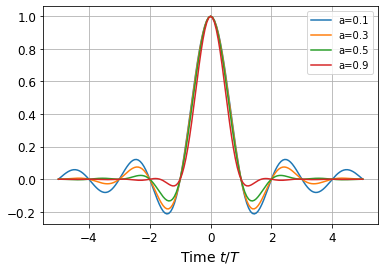

In [72]:
fsT = 16
N = 5

tt = np.linspace(-N, N, 2*N*fsT + 1)

for a in [0.1, 0.3, 0.5, 0.9]:
    plt.plot(tt, rc_pulse(a, fsT, N), label='a={:3.1f}'.format(a))
plt.grid()
plt.xlabel('Time $t/T$')
plt.legend()

plt.show()

The Fourier transform of this pulse is given by
$$
S(f) = \begin{cases}
    T & |fT| \leq \frac{1-a}{2} \\
    \frac{T}{2}(1 - \sin(\frac{\pi T}{a}(|f|-\frac{1}{2T}))) & \frac{1-a}{2} \leq |fT| \leq \frac{1+a}{2} \\
    0 & |fT| >  \frac{1+a}{2}
\end{cases}
$$

The raised cosine pulse is *strictly* band-limited and has two-sided bandwidth $\frac{1+a}{T}$. This is wwider (by $\frac{a}{T}$) than the minimum bandwidth. 

The extra bandwidth $\frac{a}{T}$ is called the *excess bandwidth*.

#### Exercise: Spectrum of raised cosine pulse

Plot the PSD of a linearly modulated signal when raised cosine pulses are used for pulse shaping. Use the same roll-off factors as in the plot above. Remember that the PSD is proportional to $|S(f)|^2$. Use a normalized frequency axis that spans from $-2 \leq fT \leq 2$.

In [73]:
# plot the spectrum of raised cosine pulse

### The Root-Raised Cosine Pulse

The Raised Cosine Pulse is a Nyquist pulse. Recall, hower, that the Nyquist criterion applies to the cascade of pulse shaping and receive filter.

Therefore, the raised cosine pulse **should not** be used as a pulse shaping filter. The cascade of two raised cosine filters - one for pulse shaping and one for matched filter - is **not** a Nyquist pulse.

Fortunately, a pulse exists such that the cascade of two such pulses yields a Nyquist pulse. This pulse is called the square-root raised cosine filter (SRRC)


### Matched Filter Output at  Receiver

When pulse shaping with Root Raised Cosine pulses and matched filtering is used, then the resulting signal is smooth (bandlimited).

Symbol rate samples fall at the symbol values since the Nyquist criterion is met.

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

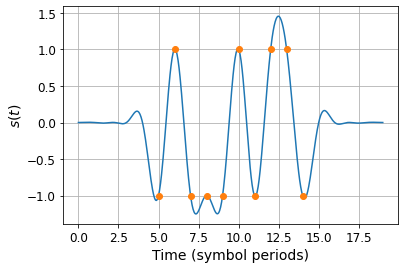

Symbols =  [-1  1 -1 -1 -1  1 -1  1  1 -1]


In [8]:
# generate 10 random BPSK symbols
A = np.array([1, -1])                        # define a BPSK constellation
sym =  random_symbols(A, 10) # select 10 symbols at random

fsT = 32
N = 5
a = 0.5

# pulse shape with RC pulse
pp = rc_pulse(a, fsT, N)
ss = pulse_shape(sym, pp, fsT)
tt = np.arange(len(ss))/fsT

# and plot
plt.plot(tt, ss)
plt.plot(np.arange(N, N+10), sym, 'o')
plt.grid()

plt.xlabel('Time (symbol periods)')
plt.ylabel('$s(t)$')

plt.show()

print('Symbols = ', sym)

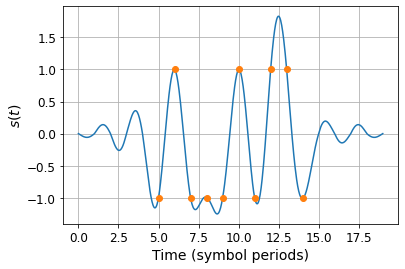

Symbols =  [-1  1 -1 -1 -1  1 -1  1  1 -1]


In [9]:
a = 0.1

# pulse shape with RC pulse
pp = rc_pulse(a, fsT, N)
ss = pulse_shape(sym, pp, fsT)
tt = np.arange(len(ss))/fsT

# and plot
plt.plot(tt, ss)
plt.plot(np.arange(N, N+10), sym, 'o')
plt.grid()

plt.xlabel('Time (symbol periods)')
plt.ylabel('$s(t)$')

plt.show()

print('Symbols = ', sym)